Importing these ig

In [29]:
import os

os.environ['KAGGLE_USERNAME'] = "anonymoususersuhp"
os.environ['KAGGLE_KEY'] = "67a93849521be8e4a7878fb3315007f7"


In [30]:
print("Okay lets train and classify these images...Idk y m i even writin this for?...meh...")

Okay lets train and classify these images...Idk y m i even writin this for?...meh...


In [31]:
from pathlib import Path
import shutil
import random

root = Path('dogs-vs-cats') / 'train'
dest_root = Path('data')

classes = ['cats', 'dogs']
train_frac = 0.8

for split in ['train', 'val']:
    for cls in classes:
        (dest_root / split / cls).mkdir(parents=True, exist_ok=True)

# Copy and split
for cls in classes:
    src_dir = root / cls
    files = [p for p in src_dir.iterdir() if p.is_file()]
    files.sort()  # deterministic order
    random.shuffle(files)
    split_idx = int(len(files) * train_frac)
    train_files = files[:split_idx]
    val_files = files[split_idx:]

    def copy_list(file_list, target_dir):
        for p in file_list:
            dest = target_dir / p.name
            if not dest.exists():
                shutil.copy2(p, dest)

    copy_list(train_files, dest_root / 'train' / cls)
    copy_list(val_files, dest_root / 'val' / cls)

# Print counts for verification
def count_files(p):
    return sum(1 for _ in p.rglob('*') if _.is_file())

# print('Counts:')
# print('data/train/cats:', count_files(dest_root / 'train' / 'cats'))
# print('data/train/dogs:', count_files(dest_root / 'train' / 'dogs'))
# print('data/val/cats:', count_files(dest_root / 'val' / 'cats'))
# print('data/val/dogs:', count_files(dest_root / 'val' / 'dogs'))
# print('Source counts (dogs-vs-cats/train):')
# print('src cats:', count_files(root / 'cats'))
# print('src dogs:', count_files(root / 'dogs'))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using device:', device)

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

train_dataset = datasets.ImageFolder('data/train', transform=transform)
val_dataset = datasets.ImageFolder('data/val', transform=transform)
print('Found classes:', train_dataset.classes)

# helper to limit per-class samples for a fast run
from collections import defaultdict

def limited_subset_by_class(dataset, per_class):
    targets = dataset.targets
    class_indices = defaultdict(list)
    for i,t in enumerate(targets):
        class_indices[t].append(i)
    indices = []
    for cls, idxs in class_indices.items():
        take = min(per_class, len(idxs))
        indices.extend(idxs[:take])
    return Subset(dataset, indices)

per_class_train = 200
per_class_val = 50

train_subset = limited_subset_by_class(train_dataset, per_class_train)
val_subset = limited_subset_by_class(val_dataset, per_class_val)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=0)

print('Train batches:', len(train_loader), 'Val batches:', len(val_loader))

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_acc = 0.0
save_path = 'cats_dogs_cnn_quick.pth'
num_epochs = 2

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total

    # validation
    model.eval()
    v_running = 0.0
    v_correct = 0
    v_total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            v_running += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels).sum().item()
            v_total += labels.size(0)
    val_loss = v_running / v_total
    val_acc = v_correct / v_total

    print(f'Epoch {epoch}/{num_epochs} - train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print('Saved best model to', save_path)

print('Done training. Best val acc:', best_acc)

Found classes: ['cats', 'dogs']
Train batches: 13 Val batches: 4
Epoch 1/2 - train_loss: 0.6976 train_acc: 0.5175 val_loss: 0.6804 val_acc: 0.5100
Saved best model to cats_dogs_cnn_quick.pth
Epoch 1/2 - train_loss: 0.6976 train_acc: 0.5175 val_loss: 0.6804 val_acc: 0.5100
Saved best model to cats_dogs_cnn_quick.pth
Epoch 2/2 - train_loss: 0.6649 train_acc: 0.5775 val_loss: 0.6490 val_acc: 0.5900
Saved best model to cats_dogs_cnn_quick.pth
Done training. Best val acc: 0.59
Epoch 2/2 - train_loss: 0.6649 train_acc: 0.5775 val_loss: 0.6490 val_acc: 0.5900
Saved best model to cats_dogs_cnn_quick.pth
Done training. Best val acc: 0.59


## Quick validation: classifying the two sets of images,....

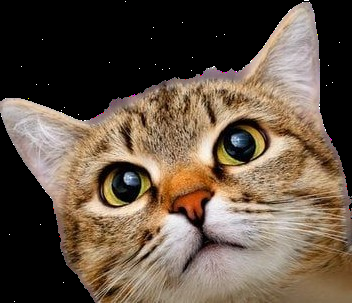

cats.jpg -> cats (63.1% cats, 36.9% dogs)


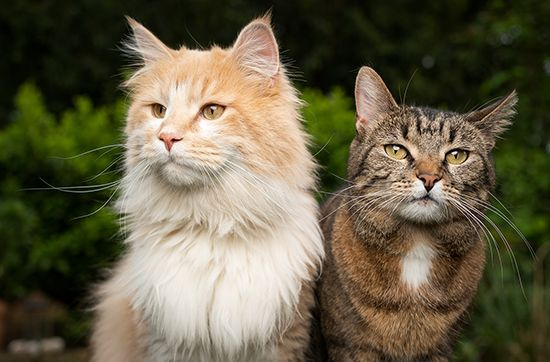

cats1.jpg -> cats (68.6% cats, 31.4% dogs)


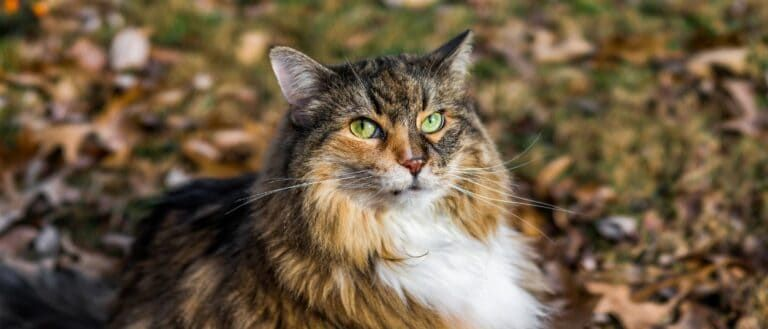

cats2.jpg -> cats (64.7% cats, 35.3% dogs)


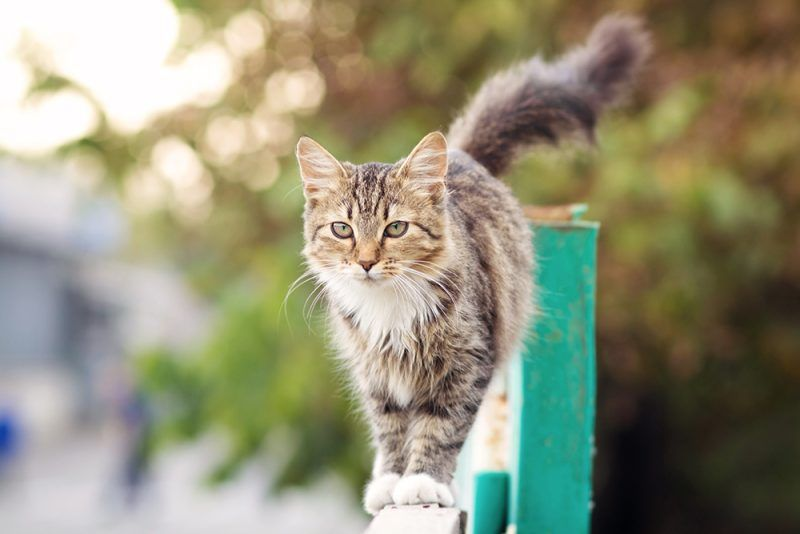

cats3.jpg -> cats (63.1% cats, 36.9% dogs)


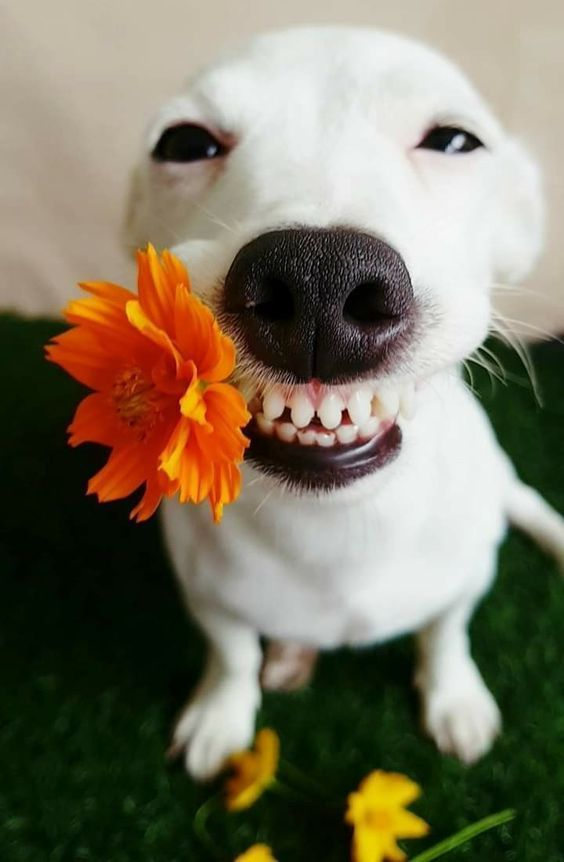

dogs.jpg -> cats (56.1% cats, 43.9% dogs)


In [32]:
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from IPython.display import display

images = ['cats.jpg','cats1.jpg','cats2.jpg','cats3.jpg', 'dogs.jpg']
model_path = 'cats_dogs_cnn_quick.pth'
classes = ['cats', 'dogs']

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# transforms (match training)
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if not Path(model_path).exists():
    print(f"Model '{model_path}' not found. Run the training cell first.")
else:
    model = SimpleCNN(num_classes=len(classes))
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.to(device).eval()

    for img_name in images:
        p = Path(img_name)
        if not p.exists():
            print(f'Image not found: {img_name}')
            continue
        img = Image.open(p).convert('RGB')
        display(img)
        x = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(x)
            probs = torch.softmax(out, dim=1)[0]
            cats_pct = float(probs[0].item()) * 100.0
            dogs_pct = float(probs[1].item()) * 100.0
            pred_idx = int(probs.argmax().item())
            pred_label = classes[pred_idx]
        print(f"{img_name} -> {pred_label} ({cats_pct:.1f}% cats, {dogs_pct:.1f}% dogs)")